In [618]:
import pandas as pd

In [619]:
economic_news_df = pd.read_csv('Full-Economic-News-DFE-839861.csv', encoding="ISO-8859-15")
economic_news_df.sample(3)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
6699,830984331,False,finalized,3,11/18/15 10:28,NaN,0.0,no,0.6639,wapo_148984591,10/30/58,Fiscal YearÛªs Tax Receipts Near Record,NaN,NaN,Federal tax collections in the year ended last...
4783,830982413,False,finalized,3,11/18/15 2:27,NaN,0.0,no,0.6691,wapo_148219889,3/16/72,Price Unit To Slow Increases: Price Boosts to ...,NaN,NaN,"The Price Commission, somewhat fearful that it..."
2206,842615667,False,finalized,3,12/5/15 11:49,NaN,NaN,no,1.0000,wsj_399084323,1/28/10,Fed Vote Kills Treasurys Rally,NaN,NaN,NEW YORK -- The first dissent vote in a year o...


In [275]:
economic_news_df.relevance.isna().sum(), economic_news_df.text.isna().sum()

(0, 0)

In [274]:
# Drop rows with 'not sure' labels
drop_index = economic_news_df[economic_news_df.relevance == 'not sure'].index
economic_news_df.drop(index=drop_index, inplace=True)
economic_news_df.shape

(7991, 15)

In [276]:
economic_news_df = economic_news_df[['text', 'relevance']]

In [277]:
economic_news_df.sample(3)

,text,relevance
2813,Author: Ruth Simon</br></br>When a borrower he...,no
6437,The Federal ReserveÛªs light-money policy is ...,no
2487,Author: Justin Lahart</br></br>A sustained and...,yes


In [278]:
relevance = economic_news_df['relevance'].map({'no': 0, 'yes': 1})
economic_news_df['relevance'] = relevance
economic_news_df.head()

/tmp/ipykernel_6701/4231271555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  economic_news_df['relevance'] = relevance


,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


In [279]:
import re
import spacy
spacy_nlp = spacy.load('en_core_web_sm')
STOPWORDS = spacy_nlp.Defaults.stop_words

In [280]:
# Clean <br> tags
def clean_br(doc):
    doc = re.sub(r'</*br>', ' ', doc)
    return doc

cleaned_text = economic_news_df['text'].map(clean_br)

In [281]:
text_filter = list(STOPWORDS) + [ '!', '"', '#', '&', '(', ')', '*', '+', '-', '.', '/',  '\\', ':', ';', '<', '=', '>',
           '?', '@', '[', ']', '^', '_', '`', '{', '|', '}', '\t','\n',"'",",",'~' , '—']

In [282]:
# $ and % sign maybe usefull in such case
'$' in text_filter

False

In [283]:
# lemmatize text with spacy
docs = spacy_nlp.pipe(cleaned_text, disable=['ner'], n_process=-1)
lemmatized_text = []
for doc in docs:
    lemmatized_text.append(' '.join([token.lemma_ for token in doc if token.lemma_ not in text_filter]))
    
lemmatized_text[:3]

['NEW YORK -- yield certificate deposit offer major bank drop tenth percentage point late week reflect overall decline short term interest rate   small denomination consumer cd sell directly bank average yield month deposit fall 5.49 % 5.62 % week end yesterday accord 18 bank survey Banxquote Money Markets Wilmington Del. information service   month consumer deposit average yield sink 5.29 % 5.42 % week accord Banxquote bank Banxquote survey Citibank New York CoreStates Pennsylvania pay 5 % threemonth small denomination cd   Declines somewhat small year consumer cd ease 7.37 % 7.45 % Banxquote   yield month month Treasury bill sell Monday auction plummet fifth percentage point previous week 5.46 % 5.63 % respectively',
 'Wall Street Journal Online   Morning Brief look day big news email subscriber 7 a.m. business day sign e mail   Friday evening Congress town summer recess Americans head mid August weekend Bush administration send message state federal government tough national child i

In [287]:
economic_news_df['lemmatized_text'] = lemmatized_text

In [288]:
from sklearn.model_selection import train_test_split
text_train, text_test, relevance_train, relevance_test = train_test_split(economic_news_df['lemmatized_text'], economic_news_df['relevance'])
len(text_train), len(relevance_test), relevance_test.sum()

(5993, 1998, 351)

In [289]:
# Check class distribution
economic_news_df['relevance'].sum()/economic_news_df.shape[0], relevance_test.sum() / len(relevance_test)

(0.17769991240145164, 0.17567567567567569)

In [336]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import word_tokenize

In [337]:
sklearn_tf_vectorizer = TfidfVectorizer(tokenizer=word_tokenize)
text_train_tf = sklearn_tf_vectorizer.fit_transform(text_train)
text_test_tf = sklearn_tf_vectorizer.transform(text_test)

sklearn_ct_vectorizer = CountVectorizer(tokenizer=word_tokenize)
text_train_ct = sklearn_ct_vectorizer.fit_transform(text_train)
text_test_ct = sklearn_ct_vectorizer.transform(text_test)

In [292]:
text_train_tf.shape, text_test_tf.shape

((5993, 43121), (1998, 43121))

In [293]:
'$' in sklearn_tf_vectorizer.vocabulary_.keys()

True

In [332]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

In [325]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(text_train_tf.toarray(), relevance_train)

y_pred_class = nb.predict(text_test_tf.toarray())
y_pred_prob = nb.predict_proba(text_test_tf.toarray())[:, 1]

In [333]:
print('Accuracy: ', accuracy_score(relevance_test, y_pred_class))
print('AUC: ', roc_auc_score(relevance_test, y_pred_prob))
print('F1-score: ', f1_score(relevance_test, y_pred_class))

Accuracy:  0.8018018018018018
AUC:  0.552473027882864
F1-score:  0.22957198443579765


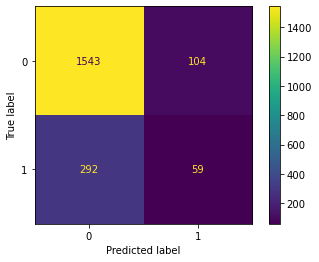

In [350]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(relevance_test, y_pred_class, labels=nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb.classes_)
disp.plot();

In [339]:
from sklearn.naive_bayes import MultinomialNB
nb_m = MultinomialNB()
nb_m.fit(text_train_ct.toarray(), relevance_train)

ct_pred_class = nb_m.predict(text_test_ct.toarray())
ct_pred_prob = nb_m.predict_proba(text_test_ct.toarray())[:, 1]

In [340]:
print('Accuracy: ', accuracy_score(relevance_test, ct_pred_class))
print('AUC: ', roc_auc_score(relevance_test, ct_pred_prob))
print('F1-score: ', f1_score(relevance_test, ct_pred_class))

Accuracy:  0.7637637637637638
AUC:  0.7438673786579071
F1-score:  0.40554156171284633


In [347]:
ct_pred_class

array([0, 0, 0, ..., 0, 0, 0])

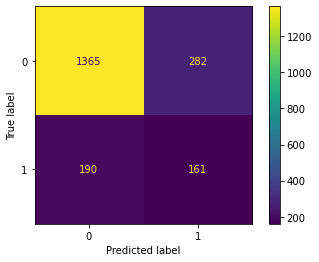

In [348]:
cm_m = confusion_matrix(relevance_test, ct_pred_class, labels=nb_m.classes_, normalize=None)
disp_m = ConfusionMatrixDisplay(confusion_matrix=cm_m,
                              display_labels=nb_m.classes_)
disp_m.plot();

In [543]:
text_train_ct.toarray().shape

(5993, 43121)

In [544]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(text_train_ct.toarray(), relevance_train)

log_pred_class = logreg.predict(text_test_ct.toarray())
log_pred_proba = logreg.predict_proba(text_test_ct.toarray())[:, 1]

In [545]:
print('Accuracy: ', accuracy_score(relevance_test, log_pred_class))
print('AUC: ', roc_auc_score(relevance_test, log_pred_proba))
print('F1-score: ', f1_score(relevance_test, log_pred_class))

Accuracy:  0.7522522522522522
AUC:  0.6815793889260798
F1-score:  0.35124508519003933


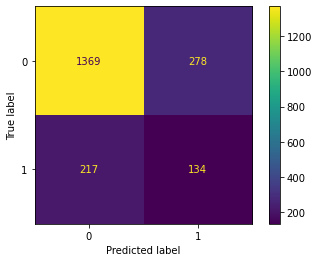

In [546]:
cm_log = confusion_matrix(relevance_test, log_pred_class, labels=logreg.classes_)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log,
                              display_labels=logreg.classes_)
disp_log.plot();

In [483]:
from sklearn.metrics import plot_roc_curve
def custom_vectorizer(vectorizer, text_train, text_test):
    train_vector = vectorizer.fit_transform(text_train)
    test_vector = vectorizer.transform(text_test)
    return train_vector, test_vector

def train_and_evaluate(model, vectorizer, text_train, text_test, relevance_train, relevance_test, **kwargs):
    exc = None
    if vectorizer != None:
        train_vector, test_vector = custom_vectorizer(vectorizer, text_train, text_test)
        train_vector, test_vector = train_vector.toarray(), test_vector.toarray()
    else:
        train_vector, test_vector = text_train, text_test
    
    model.fit(train_vector, relevance_train)

    y_pred_class = model.predict(test_vector)
    try:
        y_pred_prob = model.predict_proba(test_vector)[:, 1]
        print('AUC: ', roc_auc_score(relevance_test, y_pred_prob))
    except Exception as exc:
        print(exc)

    print('Accuracy: ', accuracy_score(relevance_test, y_pred_class))
    print('F1-score: ', f1_score(relevance_test, y_pred_class))

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(relevance_test, y_pred_class, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot();
    if exc is None :
        plot_roc_curve(model, test_vector, relevance_test)        

'LinearSVC' object has no attribute 'predict_proba'
Accuracy:  0.7062062062062062
F1-score:  0.3213872832369942


/home/sandro/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


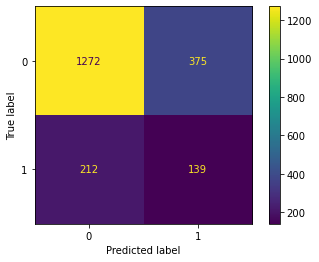

In [370]:
from sklearn.svm import LinearSVC
vectorizer = CountVectorizer(tokenizer=word_tokenize, max_features=2000)
classifier = LinearSVC(class_weight='balanced', max_iter=3000)

train_and_evaluate(model=classifier, vectorizer=vectorizer, text_train=text_train, 
                   text_test=text_test, relevance_train=relevance_train, relevance_test=relevance_test)


'LinearSVC' object has no attribute 'predict_proba'
Accuracy:  0.6976976976976977
F1-score:  0.4158607350096712


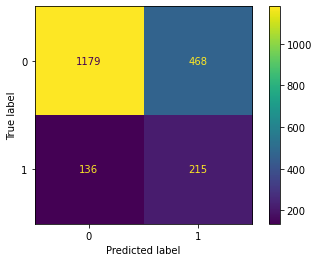

In [374]:
vectorizer = TfidfVectorizer(tokenizer=word_tokenize, max_features=1000)
classifier = LinearSVC(class_weight='balanced', max_iter=5000)

train_and_evaluate(model=classifier, vectorizer=vectorizer, text_train=text_train, 
                   text_test=text_test, relevance_train=relevance_train, relevance_test=relevance_test)


AUC:  0.7474333892063096
Accuracy:  0.8248248248248248
F1-score:  0.24892703862660945


/home/sandro/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


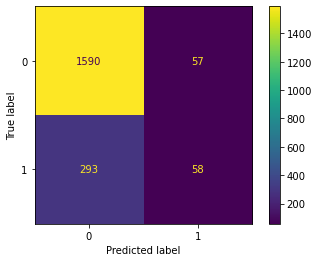

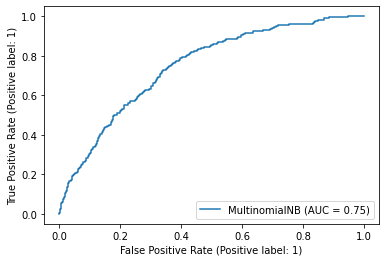

In [391]:
vectorizer = TfidfVectorizer(tokenizer=word_tokenize, max_features=1000)
classifier = MultinomialNB()

train_and_evaluate(model=classifier, vectorizer=vectorizer, text_train=text_train, 
                   text_test=text_test, relevance_train=relevance_train, relevance_test=relevance_test)


Conclusion:

Class distribution is not equal, thats why there is the big gap between accurracy score and f1 scores. All classifiers show poor f1-score, but we made the baseline. We should find a better solution.

Let's try embeddings!

In [404]:
import gensim.downloader as api
api.info()

{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1,
   'record_format': 'dict',
   'file_size': 6344358,
   'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py',
   'license': 'All files released for the task are free for general research use',
   'fields': {'2016-train': ['...'],
    '2016-dev': ['...'],
    '2017-test': ['...'],
    '2016-test': ['...']},
   'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.',
   'checksum': '701ea67acd82e75f95e1d8e62fb0ad29',
   'file_name': 'se

In [405]:
word_vectors = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [580]:
word_vectors.key_to_index

{'</s>': 0,
 'in': 1,
 'for': 2,
 'that': 3,
 'is': 4,
 'on': 5,
 '##': 6,
 'The': 7,
 'with': 8,
 'said': 9,
 'was': 10,
 'the': 11,
 'at': 12,
 'not': 13,
 'as': 14,
 'it': 15,
 'be': 16,
 'from': 17,
 'by': 18,
 'are': 19,
 'I': 20,
 'have': 21,
 'he': 22,
 'will': 23,
 'has': 24,
 '####': 25,
 'his': 26,
 'an': 27,
 'this': 28,
 'or': 29,
 'their': 30,
 'who': 31,
 'they': 32,
 'but': 33,
 '$': 34,
 'had': 35,
 'year': 36,
 'were': 37,
 'we': 38,
 'more': 39,
 '###': 40,
 'up': 41,
 'been': 42,
 'you': 43,
 'its': 44,
 'one': 45,
 'about': 46,
 'would': 47,
 'which': 48,
 'out': 49,
 'can': 50,
 'It': 51,
 'all': 52,
 'also': 53,
 'two': 54,
 'after': 55,
 'first': 56,
 'He': 57,
 'do': 58,
 'time': 59,
 'than': 60,
 'when': 61,
 'We': 62,
 'over': 63,
 'last': 64,
 'new': 65,
 'other': 66,
 'her': 67,
 'people': 68,
 'into': 69,
 'In': 70,
 'our': 71,
 'there': 72,
 'A': 73,
 'she': 74,
 'could': 75,
 'just': 76,
 'years': 77,
 'some': 78,
 'U.S.': 79,
 'three': 80,
 'million': 81

In [412]:
word_vectors['queen'].shape

(300,)

In [426]:
docs = spacy_nlp.pipe(cleaned_text, disable=['ner'], n_process=-1)
lemmatized_list = [[word.lemma_ for word in doc] for doc in docs]
lemmatized_list[0]

['NEW',
 'YORK',
 '--',
 'yield',
 'on',
 'most',
 'certificate',
 'of',
 'deposit',
 'offer',
 'by',
 'major',
 'bank',
 'drop',
 'more',
 'than',
 'a',
 'tenth',
 'of',
 'a',
 'percentage',
 'point',
 'in',
 'the',
 'late',
 'week',
 ',',
 'reflect',
 'the',
 'overall',
 'decline',
 'in',
 'short',
 '-',
 'term',
 'interest',
 'rate',
 '.',
 ' ',
 'on',
 'small',
 '-',
 'denomination',
 ',',
 'or',
 '"',
 'consumer',
 ',',
 '"',
 'cd',
 'sell',
 'directly',
 'by',
 'bank',
 ',',
 'the',
 'average',
 'yield',
 'on',
 'six',
 '-',
 'month',
 'deposit',
 'fall',
 'to',
 '5.49',
 '%',
 'from',
 '5.62',
 '%',
 'in',
 'the',
 'week',
 'end',
 'yesterday',
 ',',
 'accord',
 'to',
 'an',
 '18',
 '-',
 'bank',
 'survey',
 'by',
 'Banxquote',
 'Money',
 'Markets',
 ',',
 'a',
 'Wilmington',
 ',',
 'Del.',
 ',',
 'information',
 'service',
 '.',
 ' ',
 'on',
 'three',
 '-',
 'month',
 '"',
 'consumer',
 '"',
 'deposit',
 ',',
 'the',
 'average',
 'yield',
 'sink',
 'to',
 '5.29',
 '%',
 'from',

In [427]:
len(lemmatized_list)

7991

In [460]:
%%time
vectorized_list = np.array([np.array([word_vectors[word] for word in doc if word in word_vectors], dtype='float32') 
                            for doc in lemmatized_list])
vectorized_list.shape

CPU times: user 3.81 s, sys: 601 ms, total: 4.41 s
Wall time: 4.43 s


<timed exec>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(7991,)

In [461]:
vectorized_list.shape, vectorized_list[0][0].shape

((7991,), (300,))

In [1]:
vectorized_list = pd.Series(vectorized_list)

In [471]:
vectorized_list.map(lambda doc: doc.mean(axis=0)).shape

CPU times: user 262 ms, sys: 5.56 ms, total: 267 ms
Wall time: 269 ms


(7991,)

In [477]:
vectorized_list_mean = vectorized_list.map(lambda doc: doc.mean(axis=0))
vectorized_list_mean[0].shape

(300,)

In [566]:
vectorized_list_back = vectorized_list_mean
vectorized_list_mean = np.stack(vectorized_list_mean)
relevance.iloc[:, 0]

0       1
1       0
2       0
3       0
4       1
       ..
7986    1
7987    0
7988    0
7989    0
7990    0
Name: relevance, Length: 7991, dtype: int64

In [ ]:
relevance = relevance.reset_index(drop=True)

AUC:  0.7537740135272989
Accuracy:  0.6761761761761762
F1-score:  0.44653550042771606


/home/sandro/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


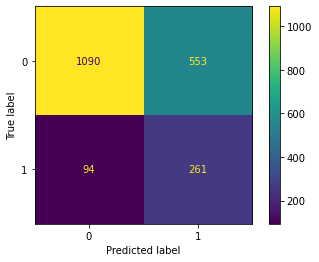

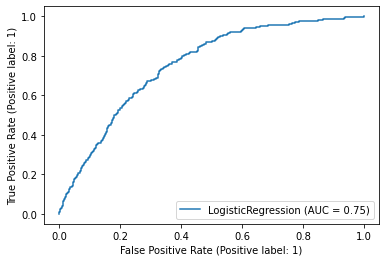

In [576]:
vectors_train, vectors_test, vec_relevance_train, vec_relevance_test = train_test_split(vectorized_list_mean, relevance.iloc[:, 0])

logreg_vec = LogisticRegression(class_weight='balanced', max_iter=2000)

train_and_evaluate(model=logreg_vec, vectorizer=None, text_train=vectors_train, 
                   text_test=vectors_test, relevance_train=vec_relevance_train, relevance_test=vec_relevance_test)

AUC:  0.6667161438197283
Accuracy:  0.7822822822822822
F1-score:  0.3317972350230414


/home/sandro/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


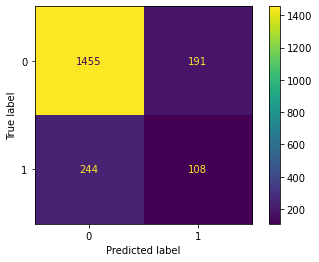

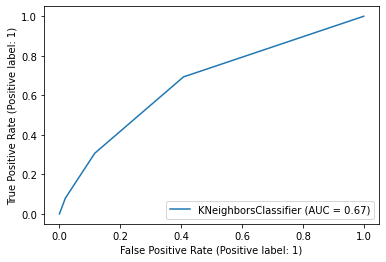

In [573]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

train_and_evaluate(model=neigh, vectorizer=None, text_train=vectors_train, 
                   text_test=vectors_test, relevance_train=vec_relevance_train, relevance_test=vec_relevance_test)


AUC:  0.6667161438197283
Accuracy:  0.7822822822822822
F1-score:  0.3317972350230414


/home/sandro/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


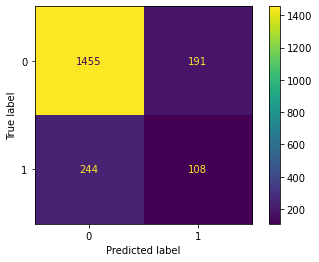

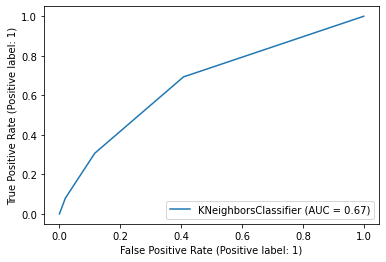

In [574]:
from sklearn.svm import LinearSVC

classifier = LinearSVC(class_weight='balanced', max_iter=3000)

train_and_evaluate(model=neigh, vectorizer=None, text_train=vectors_train, 
                   text_test=vectors_test, relevance_train=vec_relevance_train, relevance_test=vec_relevance_test)

Let's try Fasttext

In [581]:
import fasttext
help(fasttext.FastText)

Help on module fasttext.FastText in fasttext:

NAME
    fasttext.FastText

DESCRIPTION
    # Copyright (c) 2017-present, Facebook, Inc.
    # All rights reserved.
    #
    # This source code is licensed under the MIT license found in the
    # LICENSE file in the root directory of this source tree.

FUNCTIONS
    cbow(*kargs, **kwargs)
    
    eprint(*args, **kwargs)
    
    load_model(path)
        Load a model given a filepath and return a model object.
    
    read_args(arg_list, arg_dict, arg_names, default_values)
    
    skipgram(*kargs, **kwargs)
    
    supervised(*kargs, **kwargs)
    
    tokenize(text)
        Given a string of text, tokenize it and return a list of tokens
    
    train_supervised(*kargs, **kwargs)
        Train a supervised model and return a model object.
        
        input must be a filepath. The input text does not need to be tokenized
        as per the tokenize function, but it must be preprocessed and encoded
        as UTF-8. You might wan

In [585]:
economic_news_df['labels'] = '__label__' + economic_news_df['relevance'].astype(str)

In [600]:
fastt_train, fastt_test, fastt_label_train, fastt_label_test = train_test_split(economic_news_df['lemmatized_text'], economic_news_df['labels'])

In [601]:
fastt_train

5086    Arthur Andersen yesterday tentatively agree tr...
2914    NEW YORK -- good inflation news week reflect p...
448     bond investor ready bumpy ride Treasurys week ...
3988    BERLIN -- time year economy nearly world indus...
3507    successful financial professional tough decisi...
                              ...                        
4486    BASIC necessity lifeûófood fuel housing ÛÓit...
3995    MIAMI -- Florida Gov. Rick Scott campaign elec...
2091    WASHINGTON -- U.S. trade deficit unexpectedly ...
2386    NEW YORK -- weak dollar rattle U.S. bond marke...
6466    new issue government security carry low intere...
Name: lemmatized_text, Length: 5993, dtype: object

In [604]:
train_df_temp = fastt_label_train + ' ' + fastt_train
train_df_temp

5086    __label__0 Arthur Andersen yesterday tentative...
2914    __label__0 NEW YORK -- good inflation news wee...
448     __label__0 bond investor ready bumpy ride Trea...
3988    __label__0 BERLIN -- time year economy nearly ...
3507    __label__0 successful financial professional t...
                              ...                        
4486    __label__0 BASIC necessity lifeûófood fuel ho...
3995    __label__0 MIAMI -- Florida Gov. Rick Scott ca...
2091    __label__1 WASHINGTON -- U.S. trade deficit un...
2386    __label__0 NEW YORK -- weak dollar rattle U.S....
6466    __label__0 new issue government security carry...
Length: 5993, dtype: object

In [605]:
test_df_temp = fastt_label_test + ' ' + fastt_test
test_df_temp

2521    __label__1 Dow Jones Newswires   dollar modest...
6496    __label__0 NEW YORK Feb. 4ûóthe stock market ...
2356    __label__0 WASHINGTON -- wage benefit cost rem...
2160    __label__1 dollar edge lower rival weak expect...
7391    __label__0 productivityt gro^rthislbwe year fd...
                              ...                        
7082    __label__0 NEW YORK Feb. 18 AP ûó stock marke...
3885    __label__0 NEW YORK -- hairy beast inflation h...
6318    __label__0 Bush administration plan influenza ...
3233    __label__0 fly Geneva President Reagan veto $ ...
4508    __label__0 dramatic reasc number Ltnericans wo...
Length: 1998, dtype: object

In [622]:
with open('fastt_test_data', mode='a') as f:
    [f.write(f'{line}\n') for line in test_df_temp]

In [2]:
import csv
test_df_temp.to_csv('fastt_test_data', header=None, index=None, sep=' ', mode='a', quoting=csv.QUOTE_NONE)

In [623]:
with open('fastt_train_data', mode='a') as f:
    [f.write(f'{line}\n') for line in train_df_temp]

In [670]:
fast_model = fasttext.train_supervised(input="fastt_train_data", label="__label__", lr=1.0, epoch=75, loss='ova', wordNgrams=3, dim=300, thread=2, verbose=100)

Read 0M words
Number of words:  47311
Number of labels: 2
Progress: 100.0% words/sec/thread:  466691 lr:  0.000000 avg.loss:  0.028741 ETA:   0h 0m 0s  0.5% words/sec/thread:  443321 lr:  0.995446 avg.loss:  1.213613 ETA:   0h 1m 5s  1.3% words/sec/thread:  460298 lr:  0.987393 avg.loss:  0.999929 ETA:   0h 1m 2s  2.1% words/sec/thread:  465549 lr:  0.979282 avg.loss:  0.877888 ETA:   0h 1m 1s  2.9% words/sec/thread:  467030 lr:  0.971223 avg.loss:  0.778748 ETA:   0h 1m 0s  3.7% words/sec/thread:  468198 lr:  0.963138 avg.loss:  0.658611 ETA:   0h 1m 0s  4.5% words/sec/thread:  467709 lr:  0.955174 avg.loss:  0.559977 ETA:   0h 0m59s  5.3% words/sec/thread:  468378 lr:  0.947089 avg.loss:  0.484772 ETA:   0h 0m59s  6.1% words/sec/thread:  469198 lr:  0.938969 avg.loss:  0.423285 ETA:   0h 0m58s  6.9% words/sec/thread:  469592 lr:  0.930878 avg.loss:  0.376876 ETA:   0h 0m57s  8.2% words/sec/thread:  470000 lr:  0.917945 avg.loss:  0.322323 ETA:   0h 0m57s  9.0% words/sec/thread:  4694

In [672]:
test_df_temp[2160]

'__label__1 dollar edge lower rival weak expect regional manufacturing datum   Richmond Federal Reserve report Tuesday manufacturing activity central Atlantic region drop sharply month lead decline shipment new order volume   datum fundamentally alter expectation future Fed policy trader use opportunity book profit bet favor dollar soar year high early July greenback steadily fall past week investor wait signal direction Fed policy Fed policy set Open Market Committee meet Tuesday Wednesday   dollar boost early month heightened expectation Fed reduce bond buy program soon September Fed stimulus tend hurt greenback value Fed Chairman Ben Bernanke week expect moderate pace asset purchase later year   People ... wait piece evidence support refute theory long term strengthening dollar Matthew Alexy director global foreign exchange TD Securities'

In [671]:
fast_model.predict(test_df_temp[2160], k=2)

(('__label__0', '__label__1'), array([0.99720907, 0.00272499]))

In [630]:
test_df_temp[2160]

'__label__1 dollar edge lower rival weak expect regional manufacturing datum   Richmond Federal Reserve report Tuesday manufacturing activity central Atlantic region drop sharply month lead decline shipment new order volume   datum fundamentally alter expectation future Fed policy trader use opportunity book profit bet favor dollar soar year high early July greenback steadily fall past week investor wait signal direction Fed policy Fed policy set Open Market Committee meet Tuesday Wednesday   dollar boost early month heightened expectation Fed reduce bond buy program soon September Fed stimulus tend hurt greenback value Fed Chairman Ben Bernanke week expect moderate pace asset purchase later year   People ... wait piece evidence support refute theory long term strengthening dollar Matthew Alexy director global foreign exchange TD Securities'

In [673]:
for k in range(1,3):
    results = fast_model.test("fastt_test_data",k=k)
    print(f"Test Samples: {results[0]} Precision@{k} : {results[1]*100:2.4f} Recall@{k} : {results[2]*100:2.4f}")

Test Samples: 1998 Precision@1 : 81.0811 Recall@1 : 81.0811
Test Samples: 1998 Precision@2 : 50.0000 Recall@2 : 100.0000


In [648]:
economic_news_df[economic_news_df['relevance'] == 'yes'].text

1420

In [654]:
# fasttext show better performance but does it?
conf_yes = [int(fast_model.predict(doc)[0][0][-1]) for doc in economic_news_df[economic_news_df['relevance'] == 'yes'].text]
conf_yes = pd.Series(conf_no)

In [666]:
# no, even on first look it dosen't
np.array(conf_yes).mean()

0.44647887323943664

In [667]:
conf_no = [int(fast_model.predict(doc)[0][0][-1]) for doc in economic_news_df[economic_news_df['relevance'] == 'no'].text]
conf_no = pd.Series(conf_no)
conf_no

0.024805965606452596